### Dog breed classification Inference

##### Import the necessary module

In [2]:
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import time
import json
import copy

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
%%time

train_on_gpu = torch.cuda.is_available()

train_dir = "dogs"
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize(255), #square shape
                                transforms.CenterCrop(224), #square from the center of the image
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
classes = train_data.classes

model = models.resnet18(pretrained=True)


for param in model.parameters():
    param.requires_grad = False

n_inputs = model.fc.in_features

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))
model.fc = last_layer

CPU times: user 351 ms, sys: 156 ms, total: 507 ms
Wall time: 545 ms


In [1]:
#import hiddenlayer as hl

#hl_graph = hl.build_graph(model, torch.zeros([1, 3, 224, 224]))
#hl_graph.theme = hl.graph.THEMES["blue"].copy()
#hl_graph

In [5]:
%%time

print("Model Loading...")
model.load_state_dict(torch.load('model.pt', map_location='cpu'))
#torch.load('model.pt', map_location=lambda storage, location: 'cpu')
print("Model succefully loaded !")
model.eval()

Model Loading...
Model succefully loaded !
CPU times: user 53.7 ms, sys: 46.7 ms, total: 100 ms
Wall time: 126 ms


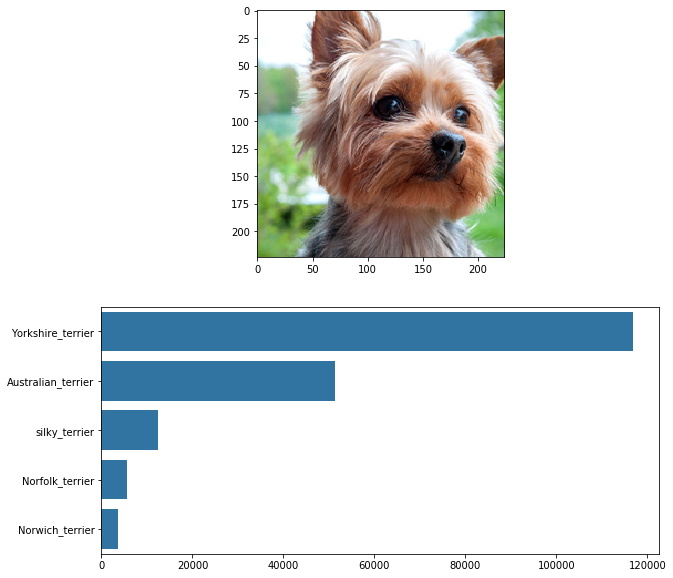

In [6]:
from PIL import Image
import numpy as np
import seaborn as sns

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    
    # Resize image
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
        
    # Crop image
    bottom_margin = (img.height-224)/2
    top_margin = bottom_margin + 224
    left_margin = (img.width-224)/2
    right_margin = left_margin + 224
    
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    
    # Normalize image
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean)/std
    
    # move to first dimension --> PyTorch
    img = img.transpose((2, 0, 1))
    
    return img




def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax



def predict(image_path, model, imageFolderVariable, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    #process image
    img = process_image(image_path)
    #transform to tensor
    tensor_img = torch.from_numpy(img).type(torch.FloatTensor)
    #batch 1
    input_model = tensor_img.unsqueeze(0)

    # doesn't work on GPU, so I moved it to cpu
    model = model.cpu()
    log_results = model(input_model)
    proba = torch.exp(log_results)

    top_proba, top_label = proba.topk(top_k)
    top_proba = top_proba.detach().numpy().tolist()[0] 
    top_label = top_label.detach().numpy().tolist()[0]

    # transform indices to classes name
    idx_to_class = {val: key for key, val in imageFolderVariable.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_label]
    
    return top_proba, [i[10:] for i in top_labels]


def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (10,10))
    ax = plt.subplot(2,1,1)

    # Plot 
    img = process_image(image_path)
    imshow(img, ax);

    # Make prediction
    probs, labs = predict(image_path, model, train_data)

    # Plot bar chart
    
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=labs, color=sns.color_palette()[0]);
    plt.show()
    
plot_solution('Yorkshire-Terrier.jpg', model)

### Plot With Bokeh

In [16]:
from bokeh.models import GeoJSONDataSource, ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [7]:
def breed_result():

    train_on_gpu = torch.cuda.is_available()

    train_dir = "dogs"
    transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.Resize(255), #square shape
                                    transforms.CenterCrop(224), #square from the center of the image
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])
    ])

    train_data = datasets.ImageFolder(train_dir, transform=transform)
    classes = train_data.classes


    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    n_inputs = model.fc.in_features
    last_layer = nn.Linear(n_inputs, len(classes))
    model.fc = last_layer


    model.load_state_dict(torch.load('model.pt', map_location='cpu'))
    model.eval()

    image_path = "Yorkshire-Terrier.jpg"
    pred_for_plot = predict(image_path, model, train_data, top_k=3)
    #pred = predict(image_path, model, train_data, top_k=3)[1]#[0]

    #return pred, image_path, pred_for_plot
    return image_path, pred_for_plot

In [19]:
%%time
breed_result()

CPU times: user 517 ms, sys: 211 ms, total: 728 ms
Wall time: 765 ms


('Yorkshire-Terrier.jpg',
 ([116812.84375, 51240.27734375, 12349.130859375],
  ['Yorkshire_terrier', 'Australian_terrier', 'silky_terrier']))

In [8]:
def plotdog():


    COLOR_BACKGROUND_MAP = 'aliceblue'
    COLOR_MAP = 'lightsteelblue'
    COLOR_LINE = 'black'
    COLOR_LOW_INTENSITY = 'yellow'
    COLOR_MEDIUM_INTENSITY = 'orange'
    COLOR_HIGH_INTENSITY = 'red'

    #_, image_path, probas_label = breed_result()
    image_path, probas_label = breed_result()
    probas = probas_label[0]
    probas = probas[::-1] #this is to reverse the list
    label = probas_label[1]
    label = label[::-1]


    p = figure(y_range=label,
        background_fill_color=(216,222,233),
        title="Top predictions", width=1000)
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.axis_line_color = None
    p.yaxis.axis_line_color = None
    p.xaxis.visible = None

    p.toolbar.logo = None
    p.toolbar_location = None
    p.border_fill_color = (216,222,233)
    p.outline_line_width = 2
    p.outline_line_color = 'black' #(216,222,233)

    p.hbar(y=label, height=0.5, left=0, right=probas, color="#CAB2D6")

    return p

In [20]:
%%time
show(plotdog())

CPU times: user 612 ms, sys: 212 ms, total: 823 ms
Wall time: 805 ms
